In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set random seed to reproduce the grid world map
np.random.seed(1234)
grids = 20
data = np.zeros((grids,grids))
data[:,0] = 1
data[:,grids-1] = 1
data[0,:] = 1
data[grids-1,:] = 1

ratio = 0.40
for i in range(2,grids-2,1):
  for j in range(1,grids-1,1):
    if np.random.rand() <= ratio:
      data[i,j] = 2

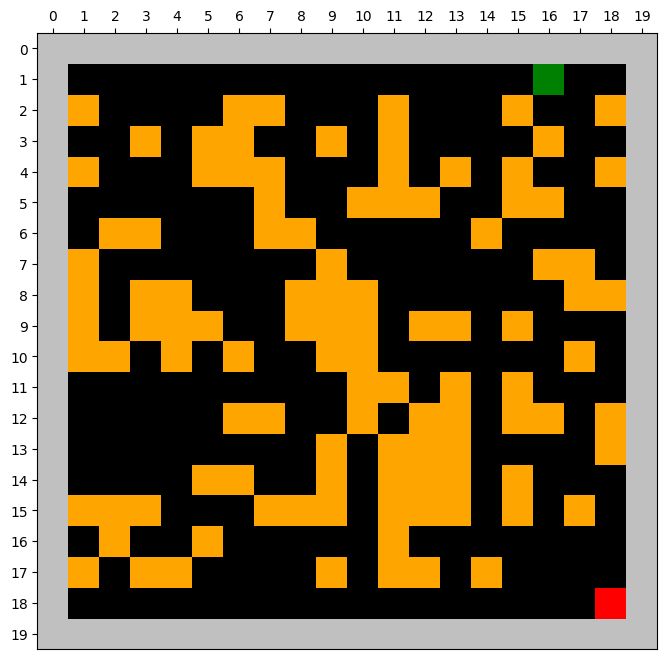

In [3]:
from matplotlib import pyplot as plt
from matplotlib import colors

startx,starty = grids-2,grids-2
data[startx,starty] = 3 #starting position
goal_y = int(np.random.rand() * (grids-3)) 
data[1,goal_y+1] = 4    #destination
'''
#0:normal 1:wall 2:obstacle 3:starting position 4:destination
'''
cmap = colors.ListedColormap(['black','silver','orange','red','green'])
fig,ax = plt.subplots(1,figsize=(8,8))
plt.pcolor(data[::-1],cmap=cmap, linewidths=1)
plt.xticks(np.arange(0.5,grids+0.5,step=1))
plt.yticks(np.arange(0.5,grids+0.5,step=1))
xlabels = ['19','18','17','16','15','14','13','12','11','10','9','8','7','6','5','4','3','2','1','0']
ylabels = ['19','18','17','16','15','14','13','12','11','10','9','8','7','6','5','4','3','2','1','0']
#ylabels = ['4','3','2','1','0']
ax.set_yticklabels(ylabels)
ax.set_xticklabels(xlabels[::-1])
ax.xaxis.tick_top()
plt.show()

In [4]:
actions_space = ['U','D','L','R'] # There are four possible actions
from numpy import linalg as LA
        
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

class  GridWorld():
    def __init__(self):
        self.current_location = [startx,starty]
        self.max_distance = LA.norm(np.array([18,1]) - np.array([1,goal_y+1]))
        
    def reset_location(self):
        self.current_location = [startx,starty]
        
    def get_reward(self, location):
        """Returns the reward for an input position"""
        norm_r = LA.norm(np.array(location) - np.array([1,goal_y+1]))
        r = 100 if data[location[0],location[1]] == 4 else (self.max_distance - norm_r)
        return r

    def check_border(self,location):
        if location[0] <= 0 or location[0] >= grids-1 :
            return 1
        elif location[1] <= 0 or location[1] >= grids-1:
            return 1
        else:
            return 0
        
    def make_step(self, action):
        # Store previous location
        last_location = self.current_location
        # UP
        if action == 'U':
            border_ = self.check_border([last_location[0]-1, last_location[1]])
            if border_ == 1:
                reward = self.get_reward(last_location)
            else:
                reward = self.get_reward([last_location[0] - 1, last_location[1]]) 
                self.current_location = [last_location[0] - 1, last_location[1]]             
        # DOWN
        elif action == 'D':
            border_ = self.check_border([last_location[0] + 1, last_location[1]])
            if border_ == 1:
                reward = self.get_reward(last_location)
            else:
                reward = self.get_reward([last_location[0] + 1, last_location[1]]) 
                self.current_location = [last_location[0] + 1, last_location[1]]

        elif action == 'L':
            border_ = self.check_border([last_location[0], last_location[1] - 1])
            if border_ == 1:
                reward = self.get_reward(last_location)
            else:
                reward = self.get_reward([last_location[0], last_location[1] - 1]) 
                self.current_location = [last_location[0], last_location[1] - 1]
                
        elif action == 'R':
            border_ = self.check_border([last_location[0], last_location[1] + 1])
            if border_ == 1:
                reward = self.get_reward(last_location)
            else:
                reward = self.get_reward([last_location[0], last_location[1] + 1]) 
                self.current_location = [last_location[0], last_location[1] + 1]
        d = 0
        cost = 1 if data[self.current_location[0],self.current_location[1]] == 2 else 0
                         
        return reward, cost, d


In [5]:
def softmax_probabilities(q_values, tau=10.0):
    exp_values = np.exp(q_values / tau)
    probabilities = exp_values / np.sum(exp_values)
    return probabilities

In [28]:
import math
from tqdm import tqdm
#CMDP Agent
class Q_Agent_cmdp():
    # Initilaze
    def __init__(self,env,use_lr=True,use_ucb=True,lr=0.1,use_greddy=True,use_epsilon=False,show_z=True,decay_step=500,total_steps=40000):
        self.env = env
        self.actions_space = ['U','D','L','R']
        self.H = 25
        self.S = (grids-2)*(grids-2)
        self.A = 4
        self.p = 0.1
        self.K = total_steps
        self.decay_step = decay_step
        self.delta = 0.03
        if use_greddy:
          self.epsilon = 1
        else:
          self.epsilon = 0
        
        self.episode_reward = []
        self.Z = 0
        self.pi = np.ones((self.H,grids,grids,4))
        self.pi_bar = np.zeros((self.H,grids,grids,self.K+1))
        self.pi_under = np.zeros((self.H,grids,grids,self.K+1))
        self.qtable_u = np.zeros((self.H,grids,grids,4)) + 800
        # self.qtable_u = np.zeros((self.H,grids,grids,4)) 
        self.ctable = np.zeros((self.H,grids,grids,4)) + 25
        self.vtable_u = np.zeros((self.H,grids,grids)) + 800
        # self.vtable_u = np.zeros((self.H,grids,grids))
        self.wtable = np.zeros((self.H,grids,grids)) + 25
        self.qtable_l = np.zeros((self.H,grids,grids,4)) 
        self.vtable_l = np.zeros((self.H,grids,grids)) 
        # self.qtable_l = np.zeros((self.H,grids,grids,4))
        # self.vtable_l = np.zeros((self.H,grids,grids))
        self.decay_step = decay_step
        self.vtable_u[self.H-1,:,:] = 0
        self.vtable_l[self.H-1,:,:] = 0
        self.wtable[self.H-1,:,:] = 0
        self.numbers = np.zeros((self.H,grids,grids,4))
        self.frame_length = int(self.K ** 0.6)
        self.rho = 20
        # self.iota =  math.log(math.sqrt(2*self.S*self.A*self.H)*self.K)
        self.iota = math.log(2*self.S*self.A*self.H*self.K)
        # self.epsilon_z = 0.5
        self.epsilon = 1
        self.eta = 0.0001 * self.K ** 0.2 * math.sqrt(self.A*self.S*self.H**4)
        print("eta is {}".format(self.eta))
        self.qhi = self.K ** 0.2
        self.episode_reward = [] 
        self.lr = lr
        self.use_lr = use_lr
        self.use_ucb = use_ucb
        self.show_z=show_z
        self.use_epsilon = use_epsilon
        
    def choose_action(self, h, state,cbar):
        if self.use_epsilon:
            if np.random.rand() < self.epsilon:
                a_ = np.random.choice(4,1)
                action = self.actions_space[a_[0]]
                return action
        if np.random.rand() <= self.delta:
            a_ = np.random.choice(4,1)
            action = self.actions_space[a_[0]]
            return action
        u_actions = self.qtable_u[h,state[0], state[1],:] + self.Z * (self.ctable[h,state[0],state[1],:] - self.rho)
        l_actions = self.qtable_l[h,state[0], state[1],:] + self.Z * (self.ctable[h,state[0],state[1],:]- self.rho)
        prob_u = softmax_probabilities(u_actions)
        prob_l = softmax_probabilities(l_actions)
        # u_action_index = np.random.choice(np.where(u_actions == u_actions.max())[0])
        # l_action_index = np.random.choice(np.where(l_actions == l_actions.min())[0])
        u_action_index = np.random.choice(4,1,p=prob_u)
        l_action_index = np.random.choice(4,1,p=prob_l)
        if u_action_index == l_action_index:
            self.pi[h,state[0],state[1],:] = 0
            self.pi[h,state[0],state[1],u_action_index] = 1
        else:
            self.pi[h,state[0],state[1],:] = 0
            self.pi[h,state[0],state[1],u_action_index] = 1- self.p
            self.pi[h,state[0],state[1],l_action_index] = self.p
        # print(self.pi[h,state[0],state[1],:])
        action_index = np.random.choice(4,1,p=self.pi[h,state[0],state[1],:])
        return self.actions_space[int(action_index)]

    def use_action(self, h, state,cbar):
        if np.random.rand() <= self.delta:
            a_ = np.random.choice(4,1)
            action = self.actions_space[a_[0]]
            return action
        # actions = self.qtable[h,state[0], state[1],:] + (self.Z / self.eta) * self.ctable[h,state[0], state[1],:]
        # action_index = np.random.choice(np.where(actions == actions.max())[0])
        u_actions = self.qtable_u[h,state[0], state[1],:] + self.Z * (self.ctable[h,state[0],state[1],:] - self.rho)
        l_actions = self.qtable_l[h,state[0], state[1],:] + self.Z * (self.ctable[h,state[0],state[1],:]- self.rho)
        prob_u = softmax_probabilities(u_actions)
        prob_l = softmax_probabilities(l_actions)
        
        # u_action_index = np.random.choice(np.where(u_actions == u_actions.max())[0])
        # l_action_index = np.random.choice(np.where(l_actions == l_actions.min())[0])
        u_action_index = np.random.choice(4,1,p=prob_u)
        l_action_index = np.random.choice(4,1,p=prob_l)
        self.pi[h,state[0],state[1],:] = 0
        if u_action_index == l_action_index:
            self.pi[h,state[0],state[1],:] = 0
            self.pi[h,state[0],state[1],u_action_index] = 1
        else:
            self.pi[h,state[0],state[1],:] = 0
            self.pi[h,state[0],state[1],u_action_index] = 1- self.p
            self.pi[h,state[0],state[1],l_action_index] = self.p
        # print(self.pi[h,state[0],state[1],:])
        action_index = np.random.choice(4,1,p=self.pi[h,state[0],state[1],:])
        return self.actions_space[int(action_index)]

    
    def learn(self, states, actions, rewards, costs, dones,trial,cbar):
        # for i in range(len(states)-1):
        #     a_index = self.actions_space.index(actions[i])
        #     self.vtable[i,states[i][0], states[i][1]] = self.qtable[i,states[i][0], states[i][1],a_index]
        #     self.wtable[i,states[i][0], states[i][1]] = self.ctable[i,states[i][0], states[i][1],a_index]
            
        for i in range(len(states)-1):
            a_index = self.actions_space.index(actions[i])
            self.numbers[i, states[i][0],states[i][1],a_index] += 1
            t = self.numbers[i,states[i][0],states[i][1],a_index]
            # alpha = 1 * (self.qhi + 1.) / (self.qhi + t) if self.use_lr else self.lr
            alpha = (self.H+ 1) / (self.H + t)
            # print(alpha,'alpha')
            # b =  0.2 * np.sqrt( np.log(self.K ) / self.numbers[i,states[i][0],states[i][1],a_index]) if self.use_ucb else 0 
            b = 0.001 * np.sqrt(self.H ** 3 * self.iota / t)
            # print(b,'b')
            if dones[i]:
                self.qtable_u[i,states[i][0], states[i][1], a_index] = (1 - alpha) * self.qtable_u[i,states[i][0], states[i][1], a_index] + alpha * (rewards[i] + b)
                self.ctable[i,states[i][0], states[i][1], a_index] = (1 - alpha) * self.ctable[i,states[i][0], states[i][1], a_index] + alpha * (costs[i]+   b)
                self.qtable_l[i,states[i][0], states[i][1], a_index] = (1 - alpha) * self.qtable_l[i,states[i][0], states[i][1], a_index] + alpha * (rewards[i] - b)
                u = self.qtable_u[i,states[i][0], states[i][1],:]+self.Z * (self.ctable[i,states[i][0],states[i][1],:] - self.rho)
                l = self.qtable_l[i,states[i][0], states[i][1],:]+self.Z * (self.ctable[i,states[i][0],states[i][1],:] - self.rho)
                u_prob = softmax_probabilities(u)
                l_prob = softmax_probabilities(l)
                self.pi_bar[i,states[i][0],states[i][1],trial+1] = np.random.choice(4,1,p=u_prob)
                self.pi_under[i,states[i][0],states[i][1],trial+1] = np.random.choice(4,1,p=l_prob)
                # self.pi_bar[i,states[i][0],states[i][1],trial+1] = np.argmax(self.qtable_u[i,states[i][0], states[i][1],:]+self.Z * (self.ctable[i,states[i][0],states[i][1],:] - self.rho))
                # self.pi_under[i,states[i][0],states[i][1],trial+1] = np.argmin(self.qtable_l[i,states[i][0], states[i][1],:]+self.Z * (self.ctable[i,states[i][0],states[i][1],:] - self.rho))
            else:
                self.qtable_u[i,states[i][0], states[i][1], a_index] = (1 - alpha) * self.qtable_u[i,states[i][0], states[i][1], a_index] + alpha * (rewards[i] + self.vtable_u[i+1,states[i+1][0],states[i+1][1]] +  b)
                self.ctable[i,states[i][0], states[i][1], a_index] = (1 - alpha) * self.ctable[i,states[i][0], states[i][1], a_index] + alpha * (costs[i] + self.wtable[i+1,states[i+1][0],states[i+1][1]] +  b)
                self.qtable_l[i,states[i][0], states[i][1], a_index] = (1 - alpha) * self.qtable_l[i,states[i][0], states[i][1], a_index] + alpha * (rewards[i] + self.vtable_l[i+1,states[i+1][0],states[i+1][1]] -  b)
                # self.pi_bar[i,states[i][0],states[i][1],trial+1] = np.argmax(self.qtable_u[i,states[i][0], states[i][1],:] +self.Z * (self.ctable[i,states[i][0],states[i][1],:] - self.rho))
                u = self.qtable_u[i,states[i][0], states[i][1],:] +self.Z * (self.ctable[i,states[i][0],states[i][1],:] - self.rho)
                # self.pi_under[i,states[i][0],states[i][1],trial+1] = np.argmin(self.qtable_l[i,states[i][0], states[i][1],:]+self.Z * (self.ctable[i,states[i][0],states[i][1],:] - self.rho))
                l = self.qtable_l[i,states[i][0], states[i][1],:] +self.Z * (self.ctable[i,states[i][0],states[i][1],:] - self.rho)
                u_prob = softmax_probabilities(u)
                l_prob = softmax_probabilities(l)
                self.pi_bar[i,states[i][0],states[i][1],trial+1] = np.random.choice(4,1,p=u_prob)
                self.pi_under[i,states[i][0],states[i][1],trial+1] = np.random.choice(4,1,p=l_prob)
                # print(int(self.pi_under[i,states[i][0],states[i][1],trial]))
                self.vtable_u[i,states[i][0],states[i][1]] = min(self.vtable_u[i,states[i][0],states[i][1]],(1-self.p) * self.qtable_u[i,states[i][0], states[i][1],int(self.pi_bar[i,states[i][0],states[i][1],trial+1])] + self.p * self.qtable_l[i,states[i][0], states[i][1],int(self.pi_under[i,states[i][0],states[i][1],trial+1])])
                self.vtable_l[i,states[i][0],states[i][1]] = max(self.vtable_l[i,states[i][0],states[i][1]],(1-self.p) * self.qtable_l[i,states[i][0], states[i][1],int(self.pi_bar[i,states[i][0],states[i][1],trial+1])] + self.p * self.qtable_l[i,states[i][0], states[i][1],int(self.pi_under[i,states[i][0],states[i][1],trial+1])])
                if self.vtable_l[i,states[i][0],states[i][1]] > (1-self.p) * self.qtable_l[i,states[i][0], states[i][1],int(self.pi_bar[i,states[i][0],states[i][1],trial+1])] + self.p * self.qtable_l[i,states[i][0], states[i][1],int(self.pi_under[i,states[i][0],states[i][1],trial+1])]:
                    self.pi_bar[i,states[i][0],states[i][1],trial+1]  = self.pi_bar[i,states[i][0],states[i][1],trial]
                # print(self.qtable_u[i,states[i][0], states[i][1], a_index],self.qtable_l[i,states[i][0], states[i][1], a_index])
    def update_z(self,cbar):
        self.Z = max(self.Z + self.rho - cbar , 0)
        
    def play(self):
        cbar = 0
        test_score = 0
        total_steps = 0
        collision = 0

        test_rewards = []
        test_costs = []
        
        for trial in tqdm(range(self.K)): # Run trials
            cumulative_reward = 0 # Initialise values of each game
            self.env.reset_location()
            actions_epi = []
            locations = []
            wall_time = 0
            self.update_z(cbar)
            # if trial % self.frame_length == 0 and trial != 0: #Reset at the beginning of each frame
            #     self.qtable_u +=  3
            #     # print(self.qtable_u)
            #     self.qtable_u[(self.qtable_u > 850) + (self.ctable > 25)] = 800
            #     self.update_z(cbar)
            #     if self.show_z:
            #       print("z at frmae {} is {}".format((trial / self.frame_length),self.Z))
            #       print("cbar at frame {} is {}".format((trial / self.frame_length),(cbar / self.frame_length)))
            #     self.numbers = np.zeros((self.H,grids,grids,4))
            #     cbar = 0.
                       
            states = []
            actions = []
            rewards = []
            costs = []
            dones = []
            states.append(self.env.current_location)
          
            for h in range(self.H):
                old_state = self.env.current_location
                action = self.choose_action(h,old_state,cbar)
                if h ==0:
                    action_index = ['U','D','L','R'].index(action)
                    cbar = self.ctable[0,states[0][0],states[0][1],int(action_index)]
                actions.append(action)
                
                reward, cost, done = self.env.make_step(action)
                cost =  1 - cost
                new_state = self.env.current_location 
                states.append(new_state)
                rewards.append(reward)
                costs.append(cost)
                
                if (cost) == 0:
                    wall_time += 1
                    
                total_steps += 1
                actions_epi.append(action)          
                cumulative_reward += reward
                
                done = 1 if h == self.H -1 else done
                dones.append(done)
                   
            self.learn(states, actions, rewards, costs, dones,trial,cbar)
            if trial % self.decay_step == 0:
                self.epsilon = self.epsilon * 0.95
      
            a1 = self.actions_space.index(actions[0])
            # cbar += self.ctable[0,states[0][0],states[0][1],a1]
          
            self.episode_reward.append(cumulative_reward) 
            if trial % 10000 == 0:
                print (f"mean reward: {np.mean(self.episode_reward)}")

            test_score,test_cost, finish_ = self.test(cbar)
            test_rewards.append(test_score)
            test_costs.append(test_cost)
        return test_rewards,test_costs


    def test(self,cbar):
        succ = 0
        test_cost = 0
        for i in range(1):
            self.env.reset_location()
            actions_epi = []
            locations = []    
            finish = 0
            locations.append(self.env.current_location)
            for h in range(self.H):
                old_state = self.env.current_location
                action = self.use_action(h,old_state,cbar)
                reward, cost, done = self.env.make_step(action) 
                succ += reward
                test_cost += cost
                actions_epi.append(action)
                locations.append(self.env.current_location)

        return succ, test_cost, finish

In [29]:
cmdp_c = []
cmdp_r = []
for i in range(1):
    np.random.seed(1234+1234*i)
    env = GridWorld()
    agent = Q_Agent_cmdp(env,show_z = False, use_ucb=True,use_lr=True, use_epsilon=True, decay_step=20,total_steps=80000)
    r_,c_ = agent.play()
    cmdp_c.append(c_)
    cmdp_r.append(r_)

cmdp_r = np.mean(cmdp_r,axis=0)
cmdp_c = np.mean(cmdp_c,axis=0)
# cmdp_c = np.mean(cmdp_c,axis=0)
#np.save("./avg_r_tripleq.npy", cmdp_r2) #Save testing rewards and costs
#np.save("./avg_c_tripleq.npy", cmdp_c2)
#np.save("./avg_c_tripleq.npy", cmdp_c2)
cmdp_r_mvg = moving_average(cmdp_r,1000) #Moving average for better visualization 
cmdp_c_mvg = moving_average(cmdp_c,1000)
a1 = plt.subplot(1,2,1)
a1.plot(cmdp_r_mvg)
a1 = plt.subplot(1,2,2)
a1.plot(cmdp_c_mvg)
plt.show()

eta is 21.517931245275836


  0%|          | 10/80000 [00:00<13:45, 96.95it/s]

mean reward: 162.026299545776


 13%|█▎        | 10010/80000 [01:55<13:18, 87.62it/s]

mean reward: 258.58592372970014


 25%|██▌       | 20011/80000 [03:55<13:34, 73.63it/s]

mean reward: 336.23117995907705


 38%|███▊      | 30016/80000 [05:58<09:52, 84.39it/s]

mean reward: 383.5742760667478


 50%|████▉     | 39687/80000 [07:57<08:04, 83.18it/s]


KeyboardInterrupt: 

In [60]:
cmdp_c_mvg[40000]

5.931

In [99]:
agent.qtable_l 

array([[[[800.        , 800.        , 800.        , 800.        ],
         [800.        , 800.        , 800.        , 800.        ],
         [800.        , 800.        , 800.        , 800.        ],
         ...,
         [800.        , 800.        , 800.        , 800.        ],
         [800.        , 800.        , 800.        , 800.        ],
         [800.        , 800.        , 800.        , 800.        ]],

        [[800.        , 800.        , 800.        , 800.        ],
         [800.        , 800.        , 800.        , 800.        ],
         [800.        , 800.        , 800.        , 800.        ],
         ...,
         [800.        , 800.        , 800.        , 800.        ],
         [800.        , 800.        , 800.        , 800.        ],
         [800.        , 800.        , 800.        , 800.        ]],

        [[800.        , 800.        , 800.        , 800.        ],
         [800.        , 800.        , 800.        , 800.        ],
         [800.        , 800.  

In [109]:
np.argmax(agent.qtable_u,axis=-1)

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 3, 2, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 3, 0],
        [0, 0, 0, ..., 3, 3, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 0, 0, ..., 3, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 1, 2, ..., 